## Среда POGEMA (Partially Observable Grid Environments for Multiple Agents)

Среда представляет собой клеточное поле с расположенными на нём агентами, их целями и препятствиями. Каждому агенту необходимо добраться до своей цели, избегая препятствий и других агентов. Пример среды, показывающей частичную наблюдаемость для одного агента:

<div>
    <img src="https://raw.githubusercontent.com/Tviskaron/pogema-pics/main/pics/pogema-obs.svg" width="600"/>
</div>

* Наблюдение представляет собой 3 матрицы. Кажда матрица центрирована относительно позиции агента. В качестве наблюдения для всех задач будет использован $R=5$ (поле 11x11 вокруг агента).
* Пространство действий: Агенту доступно 5 действий, движения в 4-ре возможные стороны и пропуск хода.
* Функция вознаграждения: Базовая функция вознаграждения -- это ``0.0`` для всех состояния, пока агент не дошел до цели и ``1.0``, когда дошёл.


## Установка

In [1]:
!pip install -q --quiet pogema

## Пример создания среды

Изменить параметры среды можно передав конфигурационный файл. Параметры, который могут быть вам полезны: 
* size – отвечает за размер окружения
* num_agents – количество агентов в среде
* density - плотность препятствий (рекомендуется использовать значения от 0.2 до 0.4, на них же будет проверяться и ваше решение)
* seed – фиксированное расположения препятствий, агентов и целей. По умолчанию выбирается случайно. Можно поставить None, для случайного выбора. Может быть полезно для проверки результатов.

In [22]:
class Node:
  
    def __init__(self, data, indexloc = None):
        self.data = data
        self.index = indexloc
        
       
class Graph:
 
    @classmethod
    def create_from_nodes(self, nodes):
        return Graph(len(nodes), len(nodes), nodes)
 
  
    def __init__(self, row, col, nodes = None):
        # установка матрица смежности
        self.adj_mat = [[0] * col for _ in range(row)]
        self.nodes = nodes
        for i in range(len(self.nodes)):
            self.nodes[i].index = i
 
    # Связывает node1 с node2
    # Обратите внимание, что ряд - источник, а столбец - назначение 
    # Обновлен для поддержки взвешенных ребер (поддержка алгоритма Дейкстры)
    def connect_dir(self, node1, node2, weight = 1):
        node1, node2 = self.get_index_from_node(node1), self.get_index_from_node(node2)
        self.adj_mat[node1][node2] = weight
  
    # Опциональный весовой аргумент для поддержки алгоритма Дейкстры
    def connect(self, node1, node2, weight = 1):
        self.connect_dir(node1, node2, weight)
        self.connect_dir(node2, node1, weight)
 
    # Получает ряд узла, отметить ненулевые объекты с их узлами в массиве self.nodes
    # Выбирает любые ненулевые элементы, оставляя массив узлов
    # которые являются connections_to (для ориентированного графа)
    # Возвращает значение: массив кортежей (узел, вес)
    def connections_from(self, node):
        node = self.get_index_from_node(node)
        return [(self.nodes[col_num], self.adj_mat[node][col_num]) for col_num in range(len(self.adj_mat[node])) if self.adj_mat[node][col_num] != 0]
 
    # Проводит матрицу к столбцу узлов
    # Проводит любые ненулевые элементы узлу данного индекса ряда
    # Выбирает только ненулевые элементы
    # Обратите внимание, что для неориентированного графа
    # используется connections_to ИЛИ connections_from
    # Возвращает значение: массив кортежей (узел, вес)
    def connections_to(self, node):
      node = self.get_index_from_node(node)
      column = [row[node] for row in self.adj_mat]
      return [(self.nodes[row_num], column[row_num]) for row_num in range(len(column)) if column[row_num] != 0]
     
  
    def print_adj_mat(self):
      for row in self.adj_mat:
          print(row)
  
    def node(self, index):
      return self.nodes[index]
    
  
    def remove_conn(self, node1, node2):
      self.remove_conn_dir(node1, node2)
      self.remove_conn_dir(node2, node1)
   
    # Убирает связь в направленной манере (nod1 к node2)
    # Может принять номер индекса ИЛИ объект узла
    def remove_conn_dir(self, node1, node2):
      node1, node2 = self.get_index_from_node(node1), self.get_index_from_node(node2)
      self.adj_mat[node1][node2] = 0   
  
    # Может пройти от node1 к node2
    def can_traverse_dir(self, node1, node2):
      node1, node2 = self.get_index_from_node(node1), self.get_index_from_node(node2)
      return self.adj_mat[node1][node2] != 0  
  
    def has_conn(self, node1, node2):
      return self.can_traverse_dir(node1, node2) or self.can_traverse_dir(node2, node1)
  
    def add_node(self,node):
      self.nodes.append(node)
      node.index = len(self.nodes) - 1
      for row in self.adj_mat:
        row.append(0)     
      self.adj_mat.append([0] * (len(self.adj_mat) + 1))
 
    # Получает вес, представленный перемещением от n1
    # к n2. Принимает номера индексов ИЛИ объекты узлов
    def get_weight(self, n1, n2):
        node1, node2 = self.get_index_from_node(n1), self.get_index_from_node(n2)
        return self.adj_mat[node1][node2]
  
    # Разрешает проводить узлы ИЛИ индексы узлов  
    def get_index_from_node(self, node):
        if not isinstance(node, Node) and not isinstance(node, int):
            raise ValueError("node must be an integer or a Node object")
        if isinstance(node, int):
            return node
        else:
            return node.index

In [23]:
a = Node("A")
b = Node("B")
c = Node("C")
d = Node("D")
e = Node("E")
f = Node("F")
 
graph = Graph.create_from_nodes([a,b,c,d,e,f])
 
graph.connect(a, b)
graph.connect(a, c)
graph.connect(a, e)
graph.connect(b, c)
graph.connect(b, d)
graph.connect(c, d)
graph.connect(c, f)
graph.connect(d, e)
 
graph.print_adj_mat()

[0, 1, 1, 0, 1, 0]
[1, 0, 1, 1, 0, 0]
[1, 1, 0, 1, 0, 1]
[0, 1, 1, 0, 1, 0]
[1, 0, 0, 1, 0, 0]
[0, 0, 1, 0, 0, 0]


In [28]:
start_point = (5, 5)

In [32]:
mas = []
mas

[]

In [81]:
matrix_obstacles = obs[0][0]
lstNodes = []

def searchNode(data, lst):
    for node in lst:
        if ((node.data["i"] == data["i"]) and (node.data["j"] == data["j"])):
            return node
    return None

#создаем узлы графа
for i in range ( len(matrix_obstacles) ): 
    for j in range ( len(matrix_obstacles[i]) ):
        if (matrix_obstacles[i][j] == 0):
            d = {}
            d["i"] = i
            d["j"] = j
            lstNodes.append(Node(d))
            #посмотрим вверх, вниз, влево и вправо
            #if (j - 1 >= 0) && (Node(str(i)+":"+str(j - 1)) in lstNodes):
                #ищем есть ли такой узел, если есть, то связываем его с текущим узлом          
graph = Graph.create_from_nodes(lstNodes)
for node in lstNodes:
    if (node.data["i"] - 1 >= 0):
        d = {}
        d["i"] = node.data["i"] - 1
        d["j"] = node.data["j"]
        nn = searchNode(d, lstNodes)
        if nn is None:
            continue
        graph.connect(node, nn)
        #print("123")
graph.print_adj_mat()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
lstNodes[11].index

(1, 0)

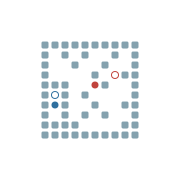

In [87]:
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import numpy as np
import pogema
from pogema import GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=2, # количество агентов на карте
                         size=8,      # размеры карты
                         density=0.3,  # плотность препятствий
                         seed=1,       # сид генерации задания 
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False, ...]

while not all(done):
    # Используем случайную стратегию
    obs, reward, done, info = env.step([np.random.randint(4) for _ in range(len(obs))])

# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=None)
display(SVG('render.svg'))

In [83]:
import numpy as np
from heapq import heappop, heappush
import gym
from pogema.animation import AnimationMonitor
from pogema import GridConfig


class Node:
    def __init__(self, coord: (int, int) = (0, 0), g: int = 0, h: int = 0):
        self.i, self.j = coord
        self.g = g
        self.h = h
        self.f = g + h

    def __lt__(self, other):
        return self.f < other.f or ((self.f == other.f) and (self.g < other.g))


class AStar:
    def __init__(self):
        self.start = (0, 0)
        self.goal = (0, 0)
        self.max_steps = 10000  # due to the absence of information about the map size we need some other stop criterion
        self.OPEN = list()
        self.CLOSED = dict()
        self.obstacles = set()
        self.other_agents = set()

    def compute_shortest_path(self, start, goal):
        self.start = start
        self.goal = goal
        self.CLOSED = dict()
        self.OPEN = list()
        heappush(self.OPEN, Node(self.start))
        u = Node()
        steps = 0
        while len(self.OPEN) > 0 and steps < self.max_steps and (u.i, u.j) != self.goal:
            u = heappop(self.OPEN)
            steps += 1
            for d in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                n = (u.i+d[0], u.j + d[1])
                if n not in self.obstacles and n not in self.CLOSED and n not in self.other_agents:
                    h = abs(n[0] - self.goal[0]) + abs(n[1] - self.goal[1])  # Manhattan distance as a heuristic function
                    heappush(self.OPEN, Node(n, u.g + 1, h))
                    self.CLOSED[n] = (u.i, u.j)  # store information about the predecessor

    def get_next_node(self):
        next_node = self.start  # if path not found, current start position is returned
        if self.goal in self.CLOSED:  # if path found
            next_node = self.goal
            while self.CLOSED[next_node] != self.start:  # get node in the path with start node as a predecessor
                next_node = self.CLOSED[next_node]
        return next_node

    def update_obstacles(self, obs, other_agents, n):
        obstacles = np.transpose(np.nonzero(obs))  # get the coordinates of all obstacles in current observation
        for obstacle in obstacles:
            self.obstacles.add((n[0] + obstacle[0], n[1] + obstacle[1]))  # save them with correct coordinates
        self.other_agents.clear()  # forget previously seen agents as they move
        agents = np.transpose(np.nonzero(other_agents))  # get the coordinates of all agents that are seen
        for agent in agents:
            self.other_agents.add((n[0] + agent[0], n[1] + agent[1]))  # save them with correct coordinates


class Model:
    def __init__(self):
        self.agents = None
        self.actions = {tuple(GridConfig().MOVES[i]): i for i in
                        range(len(GridConfig().MOVES))}  # make a dictionary to translate coordinates of actions into id

    def act(self, obs, dones, positions_xy, targets_xy) -> list:
        if self.agents is None:
            self.agents = [AStar() for _ in range(len(obs))]  # create a planner for each of the agents
        actions = []
        for k in range(len(obs)):
            if positions_xy[k] == targets_xy[k]:  # don't waste time on the agents that have already reached their goals
                actions.append(0)  # just add useless action to save the order and length of the actions
                continue
            self.agents[k].update_obstacles(obs[k][0], obs[k][1], (positions_xy[k][0] - 5, positions_xy[k][1] - 5))
            self.agents[k].compute_shortest_path(start=positions_xy[k], goal=targets_xy[k])
            next_node = self.agents[k].get_next_node()
            actions.append(self.actions[(next_node[0] - positions_xy[k][0], next_node[1] - positions_xy[k][1])])
        return actions

In [96]:
# Define random configuration
grid_config = GridConfig(num_agents=32,  # количество агентов на карте
                             size=64,  # размеры карты
                             density=0.3,  # плотность препятствий
                             seed=1,  # сид генерации задания
                             max_episode_steps=256,  # максимальная длина эпизода
                             obs_radius=5,  # радиус обзора
                             )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False for k in range(len(obs))]
solver = Model()
steps = 0
while not all(done):
    # Используем AStar
    obs, reward, done, info = env.step(solver.act(obs, done,
                                                      env.get_agents_xy_relative(),
                                                      env.get_targets_xy_relative()))
    steps += 1
    #print(steps, np.sum(done))

# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=None)

In [94]:
GridConfig().MOVES

[[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]]

## Пространство наблюдений и действий

In [12]:
grid_config = GridConfig(num_agents=2, # количество агентов на карте
                         size=8,      # размеры карты
                         density=0.3,  # плотность препятствий
                         seed=1,       # сид генерации задания 
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)

obs = env.reset()
print('Observation shape:', obs[0].shape)
print('Action space:', env.action_space)

Observation shape: (3, 11, 11)
Action space: Discrete(5)


In [24]:
# напечатаем наблюдение для одного агента
obs[0][0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1.]])

In [27]:
obs[0][1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Доступ к состоянию среды можно получить используя поле ``grid``:

In [14]:

grid = env.grid

print(grid.obstacles) # препятствия
print(grid.positions_xy) # положения агентов
print(grid.finishes_xy) # цели агентов

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Т.к. среда является многоагентной по умолчанию – она принимает список действий агентов и выдает список наблюдений. 

## Регистрация в системе codabench и отправка решений

Вам нужно зарегистрировать свою команду (название – имя команды в discord!) на [платформе проверки решений](http://46.243.226.64/competitions/1/).



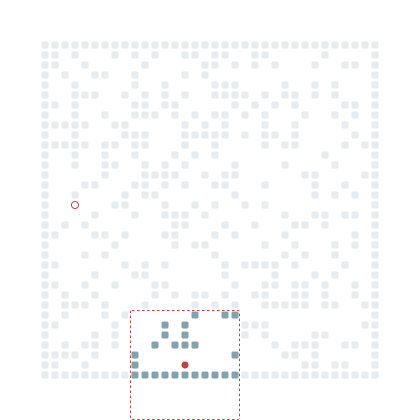

In [85]:
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import numpy as np
import pogema
from pogema import GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=1, # количество агентов на карте
                         size=32,      # размеры карты
                         density=0.3,  # плотность препятствий
                         seed=4,       # сид генерации задания 
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False, ...]


# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=0)
display(SVG('render.svg'))

In [ ]:
obs[0][2]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Интерфейс тестирования и пример случайного решения 

Вам нужно реализовать класс ```Model```, основной метод взаимодействия – ```act```. Он передает наблюдения, флаги окончания эпизода и относительные позиции положений и целей агентов (последнее может быть полезно для планировочного решения). Во время подготовки решения вы можете пользоваться полной информацией о среде, но во время тестирования ваш агент должен действовать только по информации передающейся в метод ```act```.

In [ ]:
import numpy as np


class Model:
    def __init__(self):
        """
        This should handle the logic of your model initialization like loading weights, setting constants, etc.
        """
        pass

    def act(self, obs, dones, positions_xy, targets_xy) -> list:
        """
        Given current observations, Done flags, agents' current positions and their targets, produce actions for agents.
        """
        return [np.random.randint(5) for _ in range(len(obs))]

## Получение полной информации

К этой информации не будет доступа во время тестирования!

In [ ]:
env = gym.make('Pogema-v0', grid_config=GridConfig(num_agents=2))
obs = env.reset()

print(env.get_obstacles())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
print(env.get_targets_xy())

[(12, 6), (10, 11)]


In [ ]:
print(env.get_agents_xy())

[(5, 11), (5, 5)]


## Конфигурации для тестирования

```
obs_radius=5,
max_episode_steps=256,
density – [0.2, 0.4],
num_agents – ?,
size – ? (<= 64),
seed – ?
```

## Бейслайны 

<здесь сегодня появятся ссылка>